In [51]:
import matplotlib.pyplot as plt
import pandas as pd

import warnings

warnings.filterwarnings('ignore')

In [52]:
pools = ['Pool_49', 'Pool_52', 'Pool_60']
algorithms = ['DirecTag']
alg_file = ['direcTag']

RESULT_DIR = '../../../Data/Analysis_new/'

In [53]:
experiment_data_dict = {}

for p in pools:
    pool_dict = {}
    for alg, file in zip(algorithms, alg_file):
        raw_data =pd.read_csv(
            f"../../../Data/Datasets/{p}/Thermo_SRM_{p}_01_01_3xHCD-1h-R2-tryptic/msmsScans.txt",
            sep='\t', index_col=None)
        pool_dict[alg] = raw_data [['Scan number', 'Identified', 'Sequence', 'Filtered peaks']]
    experiment_data_dict[p] = pool_dict

In [54]:
parsed_data_dict = {}

for p in pools:
    pool_dict = {}
    for alg, file in zip(algorithms, alg_file):
        parsed_data = pd.read_csv(f'../../../Data/ParsingResults/{p}/{file}_results_all_sequences.tsv', sep='\t', index_col=None)
        pool_dict[alg] = parsed_data
    parsed_data_dict[p] = pool_dict

In [55]:
scored_data_dict = {}

for p in pools:
    pool_dict = {}
    for alg, file in zip(algorithms, alg_file):
        file = file+'_scored'
        #if file == 'direcTag_scored':
         #   file = file + '_grouped'

        identified_maxquant = pd.read_csv(f'../../../Data/ScoringResults/{p}/{file}.tsv', sep='\t', index_col=None, header=0)
        identified_maxquant['by'] = 'MaxQuant'
        identified_inclusion_list= pd.read_csv(f'../../../Data/ScoringResults_Unidentified/CheckInclusionList/{p}/{file}.tsv', sep='\t', index_col=None, header=0)
        identified_inclusion_list['by'] = 'InclusionList'
        pool_dict[alg] = pd.concat([identified_maxquant, identified_inclusion_list], axis=0)
    scored_data_dict[p] = pool_dict

In [56]:
peak_distribution_dict = {}
for p in pools:
    peaks_dist =pd.read_csv(
        f"../../../Data/Datasets/{p}/mgf_peaks_distribution.tsv",
        sep='\t', index_col=None)
    peak_distribution_dict[p] = peaks_dist

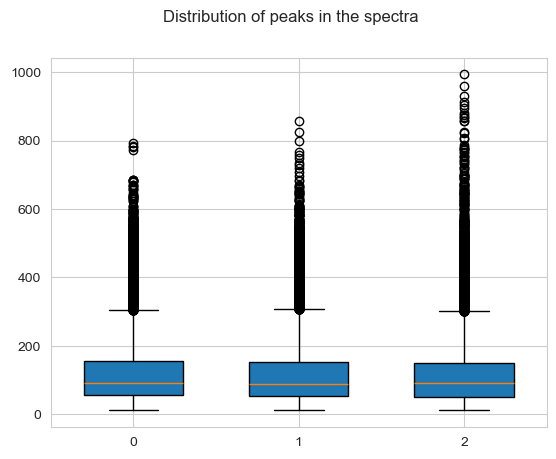

In [69]:
fig, ax = plt.subplots()
for i, p in enumerate(pools):
    raw_df = peak_distribution_dict[p].copy()
    ax.boxplot(raw_df['PeakCount'], positions=[i], widths=0.6, patch_artist=True)
fig.suptitle('Distribution of peaks in the spectra')
plt.show()

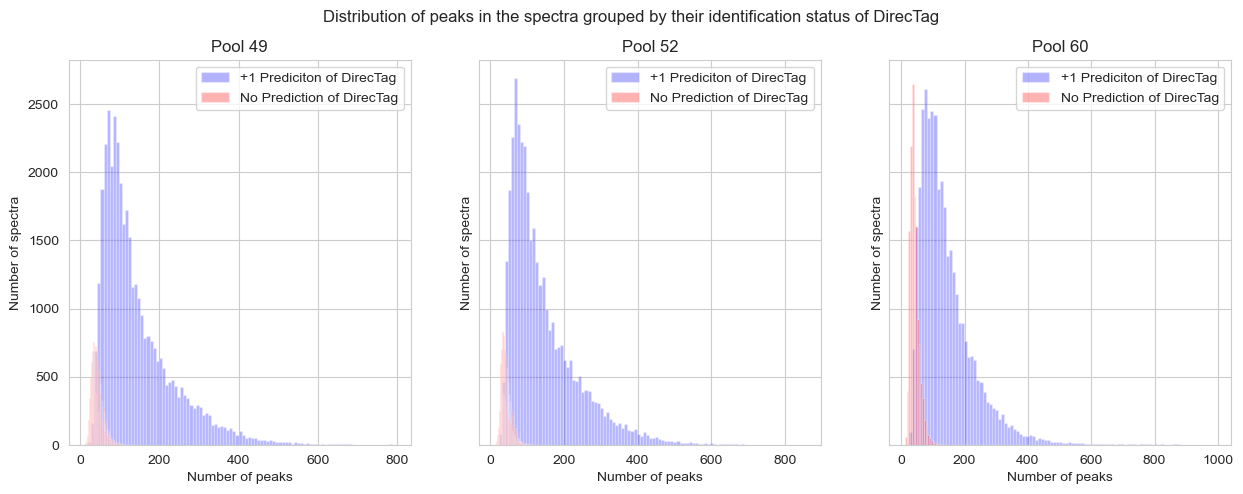

In [70]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)
for i, p in enumerate(pools):
    raw_df = peak_distribution_dict[p].copy()
    parsed_df = parsed_data_dict[p]['DirecTag'].copy()
    merged_df = pd.merge(raw_df, parsed_df, left_index=True, right_on='ID', how='left')

    merged_df = merged_df.drop_duplicates(subset='ID')

    merged_df = merged_df[['Scan_x', 'PeakCount', 'ID', 'Predicted']]

    nan_count = merged_df['Predicted'].isna().sum()

    identified_df = merged_df[merged_df['Predicted'].notna()]
    not_identified_df = merged_df[merged_df['Predicted'].isna()]

    ax[i].hist(identified_df['PeakCount'], bins=100, alpha=0.3, color='b', label='+1 Prediciton of DirecTag')
    ax[i].hist(not_identified_df['PeakCount'], bins=100, alpha=0.3, color='r', label='No Prediction of DirecTag')
    ax[i].legend()
    ax[i].set_title(f"{' '.join(p.split('_'))}")
    ax[i].set_xlabel("Number of peaks")
    ax[i].set_ylabel("Number of spectra")

fig.suptitle('Distribution of peaks in the spectra grouped by their identification status of DirecTag')
plt.show()
fig.savefig(f'{RESULT_DIR}/DirecTag/peak_distribution_direcTag.png')